In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import json
from itertools import accumulate
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pprint import pprint
from pingouin import partial_corr
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib import SimpleTable
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white, het_arch, acorr_ljungbox
from statistics import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
from scipy.stats.stats import kurtosis, skew
from scipy.stats import boxcox
from IPython.core.display import display
from patsy import dmatrices
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH
import warnings
from datetime import datetime, timedelta
import seaborn as sns

import xgboost
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.tree import export_graphviz
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

factors_dir = os.path.join('data', 'factors')

def read_csv(*args, **kwargs):
    kwargs.setdefault('parse_dates', ['Date'])
    kwargs.setdefault('index_col', 'Date')
    res = pd.read_csv(*args, **kwargs)
    if res.size < 50:
        res = res.resample('1y').last()
    elif res.size < 600:
        res = res.resample('1m').last()
    else:
        res = res.append(res.resample('1m').last())
    return res

def investing_com_convert_csv(path):
    df = pd.read_csv(path, dayfirst=True, parse_dates=['Дата'], thousands='.', decimal=',')
    df.columns = ['Date', 'Close', 'Open', 'Max', 'Min', 'Vol', 'Change']
    df = df.set_index('Date').sort_index()
    return df


def mse(fact, predict):
    return ((fact - (predict))**2).sum()/fact.shape[0]

/home/utoo/.venv_wrappers/maxim/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# Индекс реального эффективного курса рубля, инвестиции в основной капитал

In [3]:
# Создание series'ов и dataframe'ов
factors_csv = os.listdir(factors_dir)
for csv_file in factors_csv:
    if csv_file.startswith('.') or not csv_file.endswith('.csv'):
        continue
    var_name = os.path.splitext(csv_file)[0].lower()
    df_name = f'{var_name}_df'
    series_name = f'{var_name}_series'
    globals()[df_name] = read_csv(os.path.join(factors_dir, csv_file))
    globals()[series_name] = globals()[df_name].Close.resample('1d').last().dropna()

In [4]:
all_df = pd.DataFrame({
    # Индекс РТС
    'RTSI': rtsi_series,
    # Индекс S&P 500
    'SP500': sp500_series,
    # FTSE - Англия
    'FTSE': ftse_series,
    # DAX - Германия
    'DAX': dax_series,
    # SSE - Китай
    'SSE': sse_series,
    # Нефть Brent
    'Brent': brent_series,
    # USD/RUB
    'USD': usd_series,
    # Темпы роста ВВП РФ
    # 'GDP': gdp_series,
    # Золото
    'Gold': gold_series,
    # Уровень безработицы в РФ
    'Unemployment': unemployment_series,
    # Индекс потребительских цен
    # 'CPI': cpi_series,
    # Индекс потребительских цен погодично
    # 'CPI_year': cpi_year_series,
    # Индекс потребительских цен относительно 2000 года
    # 'CPI2000': cpi2000_series,
    # Индекс потребительских цен относительно 1996 года
    # 'CPI1996': cpi1996_series,
    # Ставки по межбанковским кредитам
    'InterbankRate': interbank_rate_series,
    # Доходность 6 месячных облигаций США
    'USA6mBond': usa_6m_bond_series,
    # Инвестиции в основной капитал
    # 'capital_investment': capital_investment_series,
    # Внешняя торговля РФ
    'international_trade': international_trade_series,
    # Индекс производительности труда
    'labor_performance': labor_performance_series,
    # Индекс промышленного производства
    'industrial_production': industrial_production_series,
    # Ключевая ставка
    'key_rate': key_rate_series,
    # Остатки на корреспондентских счетах
    # 'correspondent_accounts': correspondent_accounts_series,
    # Остатки на корреспондентских счетах (средние скорректированные)
    'correspondent_accounts_mean_scorr': correspondent_accounts_mean_scorr_series,
    # Номинальная зарплата
    # 'nominal_salary': nominal_salary_series,
    # Скорректированная номинальная зарплата
    'nominal_salary_scorr': nominal_salary_scorr_series,
    # ВВП РФ в абсолютном значении
    # 'abs_gdp': abs_gdp_series,
    # Скорректированный ВВП РФ в абсолютном значении
    'abs_gdp_scorr': abs_gdp_scorr_series,
    # Скорректированные инвестиции в основной капитал
    'capital_investment_scorr': capital_investment_series
})

In [ ]:
fig, ax = plt.subplots(figsize=(35, 23))
ax.tick_params(labelsize=25)
sns.heatmap(
    all_df.corr(), cmap='YlGnBu', annot=True, linewidths=2, 
    ax=ax, annot_kws={'size': 24},
    fmt='.2f'
);

In [ ]:
# Добавить dax_sp500 и sse_sp500

In [ ]:
columns = all_df.columns.drop(['RTSI'])

In [8]:
max_mc = []
# for i in range(5, len(columns)+1):
#     print(i)
#     for factors in combinations(columns, i):
#         res = np.linalg.det(all_df[list(factors)].corr())
#         if res >= .1:
#             max_mc.append((res, factors))

## Метод главных компонент

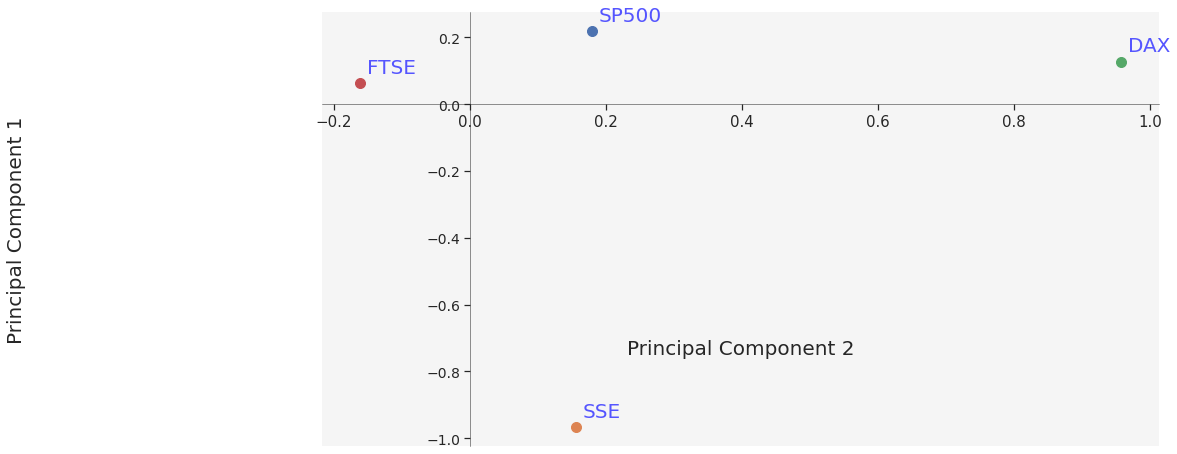

Процент объясненной дисперсии [0.93243375 0.05045146]


AttributeError: 'str' object has no attribute 'sum'

In [9]:
# Dataframe
tmp = all_df[['SP500', 'SSE', 'DAX', 'FTSE']]['1996':'2019'].resample('1y').last()
# Centering
tmp_centered = [tmp[col]-tmp[col].mean() for col in tmp.columns]
# Covariance matrix (factor loads)
tmp_cov = np.cov(tmp_centered)
tmp_eig_values, tmp_eig_vectors = np.linalg.eig(tmp_cov)
tmp_v = tmp_eig_vectors[:, 0]

for x, y, name in zip(*tmp_eig_vectors[:2], tmp.columns):
    plt.scatter(x, y, s=100);
    plt.text(x+.01, y+.03, name, fontsize=20, color='#55ff')

ax = plt.gca()
ax.set_facecolor('#bbb2')

ax.spines['left'].set_position('zero')
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_position('zero')
ax.spines['bottom'].set_linewidth(.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Principal Component 2', labelpad=210)
plt.ylabel('Principal Component 1', labelpad=400)
plt.show()

# Principal Components
pca = PCA(n_components=2)
xpca_reduced = pca.fit_transform(tmp)
print('Процент объясненной дисперсии', pca.explained_variance_ratio_)

dax_sp500 = pd.Series(xpca_reduced[:, 0], index=tmp.index)
sse_sp500 = pd.Series(xpca_reduced[:, 1], index=tmp.index)

plt.plot(
    np.append(0, np.array(list(accumulate(_)))/_.sum()),
    marker='s', markersize=10
)
plt.xticks(range(len(np.append(0, np.array(list(accumulate(_)))/_.sum()))))
plt.legend(['Explained total variance'])
plt.show()

### Расчет факторных нагрузок

In [10]:
tmp = all_df[['SP500', 'SSE', 'DAX', 'FTSE']]['1996':'2019'].resample('1y').last()
tmp_centered = [tmp[col]-tmp[col].mean() for col in tmp.columns]
tmp_cov = np.cov(tmp_centered)
_, tmp_eig = np.linalg.eig(tmp_cov)
tmp_v = tmp_eig[:, 0]

Text(0, 0.5, 'Principal Component 1')

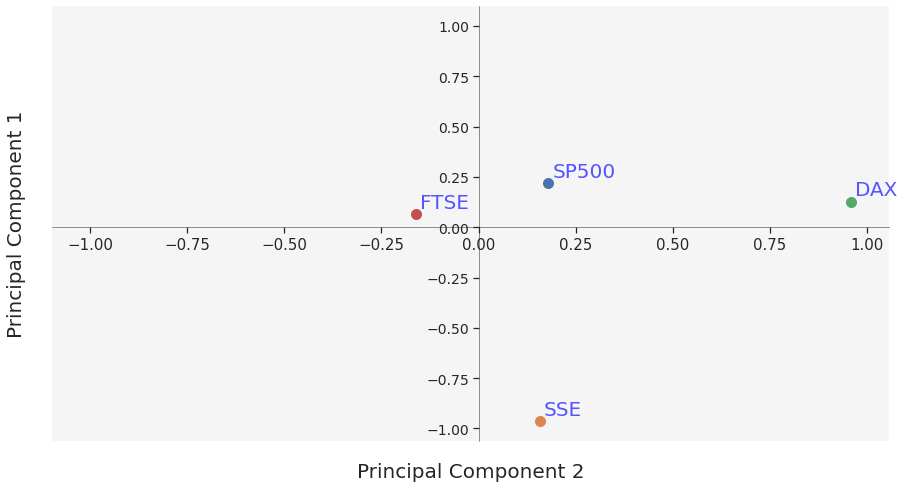

In [11]:
for x, y, name in zip(*tmp_eig[:2], tmp.columns):
    plt.scatter(x, y, s=100);
    plt.text(x+.01, y+.03, name, fontsize=20, color='#55ff')

plt.scatter(-1, 0, color='#fff0')
plt.scatter(0, 1, color='#fff0')
ax = plt.gca()
ax.set_facecolor('#bbb2')

# ax.spines['bottom'].set_color('#fff')
# ax.spines['top'].set_color('#fff') 
# ax.spines['right'].set_color('#fff')
# ax.spines['left'].set_color('#fff')

ax.spines['left'].set_position('zero')
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_position('zero')
ax.spines['bottom'].set_linewidth(.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Principal Component 2', labelpad=210)
plt.ylabel('Principal Component 1', labelpad=400)

### Расчет значений (PC)

In [12]:
pca = PCA(n_components=2)
xpca_reduced = pca.fit_transform(tmp)
print('Процент объясненной дисперсии', pca.explained_variance_ratio_)

dax_sp500 = pd.Series(xpca_reduced[:, 0], index=tmp.index)
sse_sp500 = pd.Series(xpca_reduced[:, 1], index=tmp.index)

Процент объясненной дисперсии [0.93243375 0.05045146]


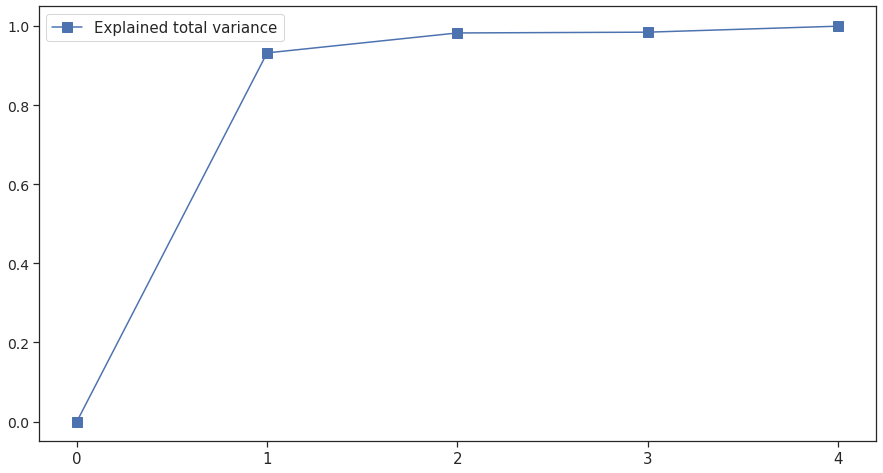

In [13]:
plt.plot(
    np.append(0, np.array(list(accumulate(_)))/_.sum()),
    marker='s', markersize=10
);
plt.scatter(0, 0, color='#0000')
plt.xticks(range(len(np.append(0, np.array(list(accumulate(_)))/_.sum()))))
plt.legend(['Explained total variance'])
plt.show()

### Поиск уравнения

In [15]:
test_df = all_df['1996':'2019'].resample('1y').last().copy()
test_df['dax_sp500'] = dax_sp500
test_df['sse_sp500'] = sse_sp500

##### Функция по поиску уравнения

In [16]:
test_df.columns

Index(['RTSI', 'SP500', 'FTSE', 'DAX', 'SSE', 'Brent', 'USD', 'Gold',
       'Unemployment', 'InterbankRate', 'USA6mBond', 'international_trade',
       'labor_performance', 'industrial_production', 'key_rate',
       'correspondent_accounts_mean_scorr', 'nominal_salary_scorr',
       'abs_gdp_scorr', 'capital_investment_scorr', 'dax_sp500', 'sse_sp500'],
      dtype='object')

In [ ]:
res = []
# Со скольки факторов искать
start_factor_count = 7
# Минимальный детерминант
min_det = .4
# try:
#     for i in range(start_factor_count, len(test_df.columns)-1):
#         print(i)
#         for factors in combinations(test_df.columns.drop('RTSI'), i):
#             fitted = smf.ols(f'RTSI ~ {"+".join(factors)}', data=test_df).fit()
#             summary = fitted.summary()
#             t_statistic = list(map(lambda x: float(x[3].data.strip()), summary.tables[1][2:]))
#             det = np.linalg.det(test_df[list(factors)].corr())
#             if (sum([abs(x) >= 2.2 for x in t_statistic]) >= len(factors)-1 and 
#                 det > min_det and
#                 ('dax_sp500' in factors or 'sse_sp500' in factors)):
#                 r2 = float(summary.tables[0][0][3].data.strip())
#                 res.append((r2, factors, det))
# except KeyboardInterrupt:
#     print('Спасибо')
# except Exception:
#     print(traceback.format_exc())
res

# Тут должна быть определена модель regression1

# Проверка предпосылок регрессионного анализа (остатков от тренда)
#### - Нулевая средняя величина
#### - Остатки подчиняются нормальному распределению
#### - Случайный характер остатков
#### - Гомоскедастичность
#### - Отсутствие автокорреляции
#### (Некоторые тесты выводятся выше при составлении тренда (Дарбин-Уотсон)

In [ ]:
regression1.summary()

In [ ]:
regression1.resid.plot();

## 1)Нулевая средняя величина 

In [ ]:
print('Средняя величина остатков:', total_regression.resid.mean())

## 2)Остатки подчиняются нормальному распределению 

### На уровне значимости 0.05, нулевая гипотеза о нормальности распределения принимается

In [ ]:
display(SimpleTable(
    np.array([sm.stats.stattools.jarque_bera(regression1.resid)]),
     ['JB', 'p-value', 'skew', 'kurtosis']
))
# Гипотеза Н0 - о нормальном распределении остатков
# Чем ближе распределение ошибок к нормальному, тем меньше статистика Харке—Бера отличается от нуля.
# При достаточно большом значении статистики p-value будет мало,
# и тогда будет основание отвергнуть нулевую гипотезу (статистика попала в «хвост» распределения). 

### Критерии ассиметрии и эксцесса, и РС

In [ ]:
variable = total_regression.resid

kurt = kurtosis(variable)
n = variable.size
kurt_critical = 5*(24*n*(n-2)*(n-3)/(n+1)**2/(n+3)/(n+4))**.5
sk = skew(variable)
sk_critical = 3*(6*(n-1)/(n+1)/(n+3))**.5

if kurt < kurt_critical:
    print(f'Эксцесс {kurt:.4f} меньше критического {kurt_critical:.4f}')
else:
    print(f'Эксцесс {kurt:.4f} больше, либо равен критическому {kurt_critical:.4f}')

if sk < sk_critical:
    print(f'Асимметрия {sk:.4f} меньше критического {sk_critical:.4f}')
else:
    print(f'Асимметрия {sk:.4f} больше, либо равна критической {sk_critical:.4f}')
    
rem = variable
# Полученное значение сравнивается с табличными 
# С вероятностью ошибки-0.05 и длиной выборки-100 РС критерий должен быть в диапазон(4.31; 5.9)
rc = (rem.max() - rem.min()) / ((rem**2).sum()/len(rem)-1)**.5
print(f'РС критерий: {rc:.4f}')

if kurt < kurt_critical and sk < sk_critical or 4.3 < rc < 5.9:
    print('Вывод: Остатки распределены нормально')
else:
    print('Вывод: Остатки не распределены нормально')

## 3)Случайный характер остатков 

In [ ]:
fuller_test = adfuller(total_regression.resid)
crit_value = fuller_test[4]

print(f'Т-статистика δ кф вспомогательного уравнения: {fuller_test[0]:.3f}')
print(f'p-value: {fuller_test[1]:.3f}')
print(f'Число наблюдений во вспомогательном уравнении: {fuller_test[3]}')
print(f'Критические значения T-статистики:')
print(f'  1%:  {crit_value["1%"]:.3f}')
print(f'  5%:  {crit_value["5%"]:.3f}')
print(f'  10%: {crit_value["10%"]:.3f}')

if fuller_test[0] > crit_value['1%']:
    print('Ряд нестационарен на 1%')
else:
    print('Ряд стационарен на 1%')

if fuller_test[0] > crit_value['5%']:
    print('Ряд нестационарен на 5%')
else:
    print('Ряд стационарен на 5%')
del fuller_test
# H0 - наличие единичного корня т.е. нестационарность ряда
# Если p-value (второе значение теста) больше критического (0.05), то мы не можем отвергнуть нулевую гипотезу
# + проверяем значение самого теста. Если значение > критического от 5%, то ряд нестационарен.

In [ ]:
total_regression_resid1 = total_regression.resid[:int(len(total_regression.resid)/2)]
total_regression_resid2 = total_regression.resid[int(len(total_regression.resid)/2):]

nom = abs(total_regression_resid1.mean() - total_regression_resid2.mean())
denom = ((total_regression_resid1.var()+total_regression_resid2.var())/2)**.5 * (1/len(total_regression_resid1)+1/len(total_regression_resid2))**.5
t = nom/denom

F = max(total_regression_resid1.var(), total_regression_resid2.var()) / min(total_regression_resid1.var(), total_regression_resid2.var())

print('Тест на равенство средних и дисперсий')
print('Т-статистика Стьюдента о равенстве средних:', t)
print('Критерий Фишера о равенстве дисперсий:', F)

In [ ]:
tf = total_regression.resid.diff().dropna().map(lambda x: x>0)
v = 1
max_len = 1
current_len = 1
for i in range(1, len(tf)):
    if tf[i] != tf[i-1]:
        v += 1
        max_len = max(max_len, current_len)
        current_len = 1
    else:
        current_len += 1

v_crit = 1/3 * (2*len(total_regression.resid)-1) - 1.96*((16*len(total_regression.resid)-29)/90)**.5

print('Количество серий:', v)
print('Максимальная длина серии:', max_len)
print('Критическое количество серий:', v_crit)

## 4)Гомоскедастичность

In [ ]:
bp_test = het_breuschpagan(total_regression.resid, total_regression.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, bp_test)))
# H0 - наличие гомоскедастичности. Если оба p-value меньше 0.05 - гетероскедастичность

In [ ]:
het_goldfeldquandt(total_regression.resid, total_regression.model.exog, store=True)
# H0 - о равенстве дисперсий в двух подвыборках (гомоскедастичность)
# Смотрим на второе число (p-value) - p-value гипотезы что дисперсии отличаются. Если большое, то гетероскедастичность

### Тест Уайта

### F-критическое ищется по таблице F(0.01; 13, 120) = 3.255

### 5.94 > F критическое => уравнение значимое => гетероскедастичность

### Если последнее число(значимость F) < 0.05 => гетероскедастичность

In [ ]:
#1 вариант - использует дисперсии
white_test = het_white(total_regression.resid, total_regression.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
display(dict(zip(labels, white_test)))
# Тест аналогичен с бройшем паганом

## 5)Проверка автокорр.

### Сравниваем эту T-статистику КФ автокорр. с T-табличным 
### (если |Tрасч|>Tтабл, то отклоняем H0 о незначимости коэф)

In [ ]:
plot_acf(total_regression.resid);
plot_pacf(total_regression.resid);

In [ ]:
_kf = acf(total_regression.resid, fft=False)[1]
t = (((_kf**2) * (total_regression.resid.size-2)) / (1-_kf**2))**.5
t

In [ ]:
#Смотрим на зону, в которую попадает это число. (Если меньше примерно 1.5, то положительная автокорреляция)
print(f'Durbin-Watson = {durbin_watson(total_regression.resid):.3f}')

In [ ]:
lb_df = acorr_ljungbox(total_regression.resid, return_df=True, lags=20)
lb_df['Quantile χ2(0.05)'] = [3.8, 6.0, 7.8, 9.5, 11.1, 12.6, 14.1, 15.5, 16.9, 18.3, 19.7, 21.0, 22.4, 23.7, 25.0, 26.3, 27.6, 28.9, 30.1, 31.4]
lb_df.head(5)

In [ ]:
lb_df[['lb_stat', 'Quantile χ2(0.05)']][:5].plot();

In [ ]:
with open('res.json') as f:
    _ = json.load(f)

In [ ]:
test_df.columns

In [ ]:
list(filter(lambda x: len(x[1]) > 3 and ('dax_sp500' in x[1] or 'sse_sp500' in x[1]) and 'FTSE' not in x[1] and 'SP500' not in x[1] and 'DAX' not in x[1] and 'SSE' not in x[1] and 'Brent' in x[1], _))

In [ ]:
list(filter(lambda x: len(x[1]) > 3 and 'Brent' in x[1] and 'dax_sp500' in x[1], _))

In [ ]:
list(filter(lambda x: len(x[1]) > 4, _))

In [17]:
factors = ['Brent',
   'industrial_production',
   'correspondent_accounts_mean_scorr',
   'sse_sp500']
# factors = ['Brent', 'labor_performance', 'dax_sp500', 'sse_sp500']
total_regression = smf.ols(f'RTSI ~ {"+".join(factors)}', data=test_df).fit()

In [18]:
total_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RTSI   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     26.74
Date:                Fri, 22 May 2020   Prob (F-statistic):           1.42e-07
Time:                        01:02:11   Log-Likelihood:                -165.46
No. Observations:                  24   AIC:                             340.9
Df Residuals:                      19   BIC:                             346.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                         -1304.8863   1139.723     -1.145      0.266   -3690.354    1080.582
Brent                                12.3097      2.262      5.441      0.000       7.575      17.045
industrial_production                12.9975     11.120      1.169      0.257     -10.276      36.271
correspondent_accounts_mean_scorr     0.0045      0.002      2.430      0.025       0.001       0.008
sse_sp500                             0.2528      0.079      3.189      0.005       0.087       0.419
==============================================================================
Omnibus:                       11.143   Durbin-Watson:                   1.312
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                9.850
Skew:                           1.156   Prob(JB):                      0.00726
Kurtosis:                       5.122   Cond. No.                     1.36e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

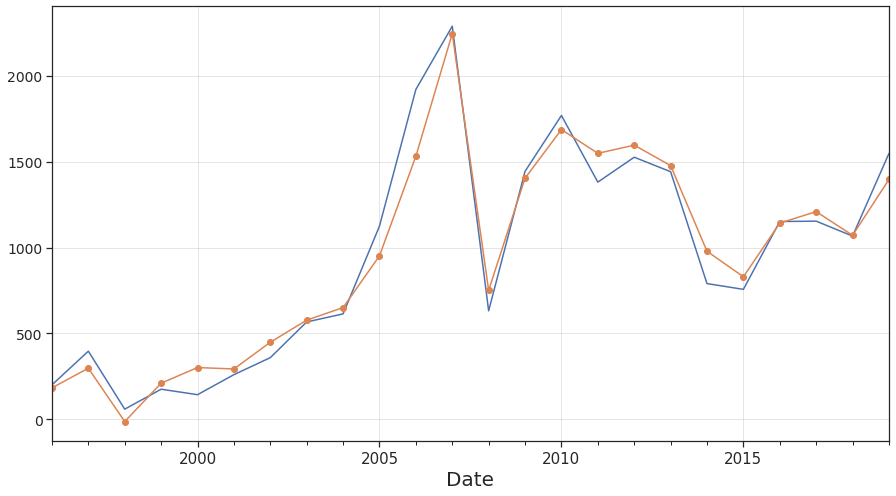

15000.0

In [84]:
test_df.RTSI.plot()
_ = total_regression.fittedvalues.copy()
# _[9] += 300.
# _[10] += 600
# _[15] -= 300
_ += (test_df.RTSI - _)/2.0534904477084217
_.plot(marker='o')
plt.grid(True)
plt.show()
mse(test_df.RTSI, _)

In [ ]:
tmp = total_regression.resid.copy()
# tmp['2006-12-31'] = 100
tmp.plot()
print(tmp.mean())
del tmp

In [ ]:
smf.ols(f"RTSI ~ {'+'.join(['Brent', 'labor_performance', 'dax_sp500', 'sse_sp500'])}", data=test_df).fit().summary()

In [25]:
mse(test_df.RTSI, smf.ols(f"RTSI ~ {'+'.join(['Brent', 'labor_performance', 'dax_sp500', 'sse_sp500'])}", data=test_df).fit().fittedvalues)

53514.44736558525